In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit

from tqdm import tqdm
from typing import List, Optional, Tuple

from catboost import cv, CatBoostClassifier, Pool

%matplotlib inline
sns.set(font_scale=1.25)

Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

Задание 4: преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

## Задание 0 

Выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели.

Данные для обучения и теста:

In [2]:
train_df = pd.read_csv('assignment_train.csv')
train_df.head(n=5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_df = pd.read_csv('assignment_test.csv')
test_df.head(n=5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3062002,0,1643519,49.0,W,14935,543.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3062003,0,1643519,100.0,R,8394,490.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3062004,0,1643529,97.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Размерности датафреймов:

In [4]:
print("train_df.shape = {} rows, {} cols".format(*train_df.shape))
print("test_df.shape = {} rows, {} cols".format(*test_df.shape))

train_df.shape = 50001 rows, 394 cols
test_df.shape = 75000 rows, 394 cols


Узнаем типы признаков:

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


Базовый анализ целевого признака (мошенничество ли?):

In [7]:
target_column = 'isFraud'

In [8]:
train_df[target_column].value_counts(normalize=True)

0    0.972861
1    0.027139
Name: isFraud, dtype: float64

In [9]:
numeric_features = train_df.select_dtypes(exclude='object').columns

X = train_df[numeric_features].drop(columns=['TransactionID', 'isFraud', 'TransactionDT']).fillna(-9999)
y = train_df[target_column]

In [10]:
X_test = test_df[numeric_features].drop(columns=['TransactionID', 'isFraud', 'TransactionDT']).fillna(-9999)
y_test = test_df[target_column]

В прошлом задании лучше всего показала себя GroupKFold:

In [11]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [12]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          proba: bool,
                          cv_strategy: object,
                          use_groups: bool = False,
                          groups: pd.Series = None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    proba: bool
        Флаг - расчитывать ли вероятностные
        предсказания для метрики.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    
    splits = cv_strategy.split(X, y, groups) if use_groups else cv_strategy.split(X, y)
    for fold_number, (train_idx, valid_idx) in enumerate(splits):
        x_train, x_valid = X[X.index.isin(train_idx)], X[X.index.isin(valid_idx)]
        y_train, y_valid = y[y.index.isin(train_idx)], y[y.index.isin(valid_idx)]

        estimator.fit(x_train, y_train)
        
        if proba:
            y_train_pred = estimator.predict_proba(x_train)[:, 1]
            y_valid_pred = estimator.predict_proba(x_valid)[:, 1]
        else:
            y_train_pred = estimator.predict(x_train)
            y_valid_pred = estimator.predict(x_valid)
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred
        
        np.random.seed(42)
        scores = create_bootstrap_metrics(y_valid, y_valid_pred, metric)
        confidence_interval = [round(bound, 3) for bound in calculate_confidence_interval(scores)]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print(f'(confidence interval: {confidence_interval})')
        print("="*69)
        
        estimator = estimator.copy()
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [13]:
import hashlib

def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6'])+
         x["ProductCD"])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [14]:
user_features = [f'card{i}' for i in range(1, 6+1)] + ['ProductCD']

train_uids = train_df[user_features].apply(lambda x: card_info_hash(x), axis=1)

In [15]:
gcv_strategy = GroupKFold(n_splits=5)
catb = CatBoostClassifier(eval_metric='AUC', n_estimators=130, silent=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9563, valid-score = 0.8187
(confidence interval: [0.785, 0.85])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9492, valid-score = 0.8384
(confidence interval: [0.814, 0.865])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9483, valid-score = 0.7511
(confidence interval: [0.714, 0.787])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9451, valid-score = 0.8472
(confidence interval: [0.823, 0.873])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9484, valid-score = 0.8784
(confidence interval: [0.85, 0.903])
CV-results train: 0.9495 +/- 0.004
CV-results valid: 0.8267 +/- 0.042
OOF-score = 0.8262


Метрика на тестовых данных попадает в доверительный интервал, поэтому этот способ валидации самый лучший из рассмотренных:

In [16]:
test_score = roc_auc_score(y_test, estimators[4].predict_proba(X_test)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8507


Итоги этой валидации будут бейзлайном для остальных заданий.

## Задание 1

Признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [17]:
train_transactiondt = \
    pd.to_datetime(train_df['TransactionDT'], unit='s') - pd.to_datetime('1970, 1, 1') + pd.to_datetime('2017, 12, 1')

train_transactiondt.head(n=5)

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]

In [18]:
test_transactiondt = \
    pd.to_datetime(test_df['TransactionDT'], unit='s') - pd.to_datetime('1970, 1, 1') + pd.to_datetime('2017, 12, 1')

test_transactiondt.head(n=5)

0   2017-12-20 00:31:32
1   2017-12-20 00:31:53
2   2017-12-20 00:31:59
3   2017-12-20 00:31:59
4   2017-12-20 00:32:09
Name: TransactionDT, dtype: datetime64[ns]

In [19]:
def make_time_features(time_series):
    L = ['year', 'month', 'day', 'hour', 'dayofweek']    
    date_gen = (getattr(time_series.dt, i).rename(i) for i in L)
    time_features = pd.concat(date_gen, axis=1)
    return time_features

In [20]:
train_time_features = make_time_features(train_transactiondt)
train_time_features.head(n=5)

,year,month,day,hour,dayofweek
0,2017,12,2,0,5
1,2017,12,2,0,5
2,2017,12,2,0,5
3,2017,12,2,0,5
4,2017,12,2,0,5


In [21]:
test_time_features = make_time_features(test_transactiondt)
test_time_features.head(n=5)

,year,month,day,hour,dayofweek
0,2017,12,20,0,2
1,2017,12,20,0,2
2,2017,12,20,0,2
3,2017,12,20,0,2
4,2017,12,20,0,2


In [22]:
X_tf = pd.concat([X, train_time_features], axis=1)
X_test_tf = pd.concat([X_test, train_time_features], axis=1)

Групповая кросс-валидация на данных с временными признаками:

In [23]:
estimators, _, _, _, _ = make_cross_validation(
    X_tf, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9539, valid-score = 0.8288
(confidence interval: [0.799, 0.86])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9527, valid-score = 0.8231
(confidence interval: [0.798, 0.851])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.946, valid-score = 0.7579
(confidence interval: [0.719, 0.796])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9538, valid-score = 0.8676
(confidence interval: [0.844, 0.89])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9488, valid-score = 0.8666
(confidence interval: [0.839, 0.891])
CV-results train: 0.951 +/- 0.003
CV-results valid: 0.8288 +/- 0.04
OOF-score = 0.8286


In [24]:
test_score = roc_auc_score(y_test, estimators[3].predict_proba(X_test_tf)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8491


Метрика немного выросла, но на отложенных данных для теста просела - добавление временных признаков дало некоторое переобучение модели.

## Задание 2

Сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

In [25]:
X_crd, X_test_crd = X.copy(), X_test.copy()

Добавим временно признаки card1...card6:

In [26]:
card_features = user_features[:-1]
X_crd[card_features] = train_df[card_features]
X_test_crd[card_features] = test_df[card_features]

Сгруппируем их, вычислим среднюю сумму транзакции по каждому значению и добавим в выборки:

In [27]:
for feature in tqdm(card_features):
    for df in (X_crd, X_test_crd):
        df_gb = df[[feature, 'TransactionAmt']].groupby(by=[feature]).mean()
        df_gb.columns = [feature+'_mean']
        df_gb.reset_index(inplace=True)
        df_gb = df[[feature]].merge(df_gb, on=feature, how='left')
        df[feature+'_mean'] = df_gb[feature+'_mean'].values

100%|████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


Добавим идентификаторы пользователей и также вычислим среднюю сумму транзакции для каждого из них:

In [28]:
X_crd['UID'] = train_uids
X_test_crd['UID'] = test_df[user_features].apply(lambda x: card_info_hash(x), axis=1)

In [29]:
for df in (X_crd, X_test_crd):
    df_gb = df[['UID', 'TransactionAmt']].groupby(by=['UID']).mean()
    df_gb.columns = ['TransactionAmtMean']
    df_gb.reset_index(inplace=True)
    df_gb = df[['UID']].merge(df_gb, on='UID', how='left')
    df['TransactionAmtMean'] = df_gb['TransactionAmtMean'].values

Зависимости средней суммы транзакций по каждому пользователю от того же по признакам card1...card6 - на данныхдля обучения и теста:

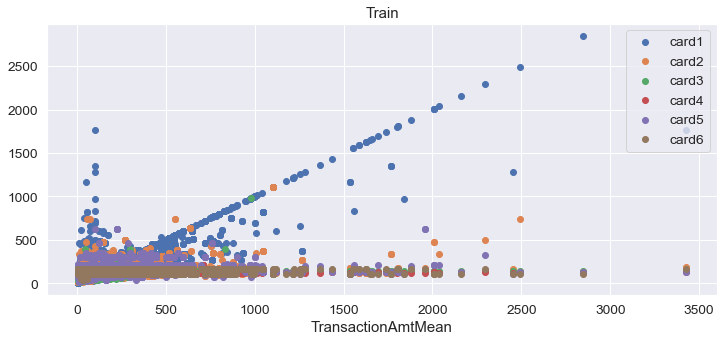

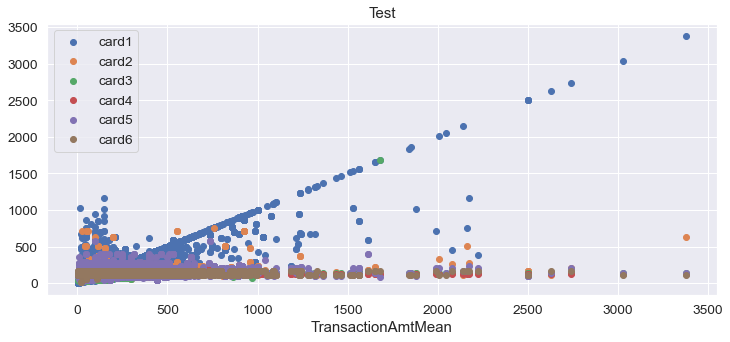

In [30]:
for df, df_type in zip([X_crd, X_test_crd], ['Train', 'Test']):
    plt.figure(figsize=(12, 5))
    for feature in card_features:
        plt.scatter(df['TransactionAmtMean'], df[feature+'_mean'], label=feature)
    plt.title(df_type)
    plt.xlabel('TransactionAmtMean')
    plt.legend(loc='best')
    plt.show()

 - явная линейная зависимость у признака catd1;
 - скорее константная зависимость у остальных (наиболее чётко выраженная у card6).

Удалим временно добавленные признаки:

In [31]:
X_crd = X_crd.drop(columns=['card4', 'card6', 'UID']).fillna(-9999)
X_test_crd = X_test_crd.drop(columns=['card4', 'card6', 'UID']).fillna(-9999)

Групповая кросс-валидация с добавленными средними суммами транзакций:

In [32]:
estimators, _, _, _, _ = make_cross_validation(
    X_crd, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9565, valid-score = 0.8092
(confidence interval: [0.776, 0.841])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9491, valid-score = 0.8318
(confidence interval: [0.804, 0.859])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.947, valid-score = 0.8722
(confidence interval: [0.851, 0.894])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.955, valid-score = 0.8561
(confidence interval: [0.83, 0.881])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9558, valid-score = 0.8923
(confidence interval: [0.865, 0.916])
CV-results train: 0.9527 +/- 0.004
CV-results valid: 0.8523 +/- 0.029
OOF-score = 0.8508


In [33]:
test_score = roc_auc_score(y_test, estimators[2].predict_proba(X_test_crd)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8504


Метрика на кросс-валидации выросла, но на отложенных данных для теста не особо существенно уменьшилась (было 0.8507).

## Задание 3

Преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [34]:
X_crd, X_test_crd = X.copy(), X_test.copy()

In [35]:
X_crd[card_features] = train_df[card_features]
X_test_crd[card_features] = test_df[card_features]

Объединим признаки из данных для обучения и теста и произведём Frequency Encoding:

In [36]:
X_adv = pd.concat(
    [X_crd, X_test_crd],
    axis=0
)

In [37]:
for feature in card_features:
    freq_encoder = X_adv[feature].value_counts(normalize=True, dropna=False)
    X_adv[feature] = X_adv[feature].map(freq_encoder)

Разобьём данные обратно:

In [38]:
X_crd = X_adv[0:50001]
X_test_crd = X_adv[50001:]

Групповая кросс-валидация с Frequency Encoding:

In [39]:
estimators, _, _, _, _ = make_cross_validation(
    X_crd, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9541, valid-score = 0.8131
(confidence interval: [0.78, 0.846])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9554, valid-score = 0.8426
(confidence interval: [0.818, 0.868])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9442, valid-score = 0.8475
(confidence interval: [0.821, 0.875])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.949, valid-score = 0.8524
(confidence interval: [0.826, 0.878])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9515, valid-score = 0.8515
(confidence interval: [0.821, 0.88])
CV-results train: 0.9508 +/- 0.004
CV-results valid: 0.8414 +/- 0.015
OOF-score = 0.8429


In [40]:
test_score = roc_auc_score(y_test, estimators[3].predict_proba(X_test_crd)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8527


Есть прирост метрики на кросс-валидации и на отложенны данных. Будем дальше работать с закодированными признаками.

## Задание 4

Преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

In [41]:
X_log, X_test_log = X_crd.copy(), X_test_crd.copy()

In [42]:
for df in (X_log, X_test_log):
    df['TransactionAmtInt'] = df['TransactionAmt'].apply(lambda x: int(np.log(x)))
    df['TransactionAmtDec'] = df.apply(lambda x: np.log(x['TransactionAmt']) - x['TransactionAmtInt'], axis=1)

In [43]:
X_log[['TransactionAmt', 'TransactionAmtInt', 'TransactionAmtDec']].head(n=5)

,TransactionAmt,TransactionAmtInt,TransactionAmtDec
0,68.5,4,0.226834
1,29.0,3,0.367296
2,59.0,4,0.077537
3,50.0,3,0.912023
4,50.0,3,0.912023


Групповая кросс-валидация с логарифмированием и разбиением TransactionAmt:

In [44]:
estimators, _, _, _, _ = make_cross_validation(
    X_log, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.955, valid-score = 0.8011
(confidence interval: [0.769, 0.834])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9537, valid-score = 0.8385
(confidence interval: [0.813, 0.862])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9452, valid-score = 0.8369
(confidence interval: [0.813, 0.863])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9523, valid-score = 0.8702
(confidence interval: [0.848, 0.89])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9509, valid-score = 0.8558
(confidence interval: [0.823, 0.884])
CV-results train: 0.9514 +/- 0.003
CV-results valid: 0.8405 +/- 0.023
OOF-score = 0.8418


In [45]:
test_score = roc_auc_score(y_test, estimators[3].predict_proba(X_test_log)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8511


Метрика получила прирост на CV-results valid и OOF-score, но просела на CV-results train и отложенных данных для теста.

## Задание 5

Для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

Остановимся на 10 компонентах:

In [46]:
pca = PCA(n_components=10, svd_solver='full')

In [47]:
%%time
X_pca = pca.fit_transform(X_crd)

Wall time: 7.94 s


In [48]:
%%time
X_test_pca = pca.transform(X_test_crd)

Wall time: 367 ms


In [49]:
pca_features = [f'pca_{i}' for i in range(1, X_pca.shape[1]+1)]
pca_features[-5:]

['pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10']

In [50]:
X_pca = pd.concat(
    [X_crd, pd.DataFrame(X_pca, columns=pca_features)],
    axis=1
)

X_test_pca = pd.concat(
    [X_test_crd, pd.DataFrame(X_test_pca, columns=pca_features)],
    axis=1
)

Групповая кросс-валидация с добавленными 10 главными компонентами:

In [51]:
estimators, _, _, _, _ = make_cross_validation(
    X_pca, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.957, valid-score = 0.8172
(confidence interval: [0.786, 0.847])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9553, valid-score = 0.827
(confidence interval: [0.8, 0.855])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9498, valid-score = 0.8452
(confidence interval: [0.818, 0.872])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9511, valid-score = 0.8605
(confidence interval: [0.836, 0.884])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9526, valid-score = 0.8604
(confidence interval: [0.83, 0.89])
CV-results train: 0.9531 +/- 0.003
CV-results valid: 0.8421 +/- 0.017
OOF-score = 0.842


In [52]:
test_score = roc_auc_score(y_test, estimators[4].predict_proba(X_test_pca)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8563


Добавление 10 главных компонент дало прирост качества на кросс-валидации и на отложенных данных. Другие количества комнент и их результаты на отложенных данных (чем больше, тем ниже метрика):
 - 50 - 0.8554;
 - 100 - 0.8464;
 - 200 - 0.8418;
 - 'mle' (378) - 0.8398.

При этом с увеличением количества компонент увеличивается и время обучения.

## Задание 6

Использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

*функция из ноутбука вебинара*

In [53]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict_proba(x_valid)[:, 1]
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict_proba(x_valid_copy)[:, 1]
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

Разобьём данные для обучения на обучающую и валидационную выборку с учётом пользователей:

In [54]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

for train_idx, valid_idx in gss.split(X_pca, y, groups=train_uids):
    x_train, x_valid = X_pca[X_pca.index.isin(train_idx)], X_pca[X_pca.index.isin(valid_idx)]
    y_train, y_valid = y[y.index.isin(train_idx)], y[y.index.isin(valid_idx)]

Обучим классификатор на обучающей выборке:

In [55]:
%%time
catb.fit(x_train, y_train)

Wall time: 14.1 s


Значения метрики на обучающей и валидационной выборках, а также на данных для теста:

In [56]:
train_score = roc_auc_score(y_train, catb.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, catb.predict_proba(x_valid)[:, 1])
test_score = roc_auc_score(y_test, catb.predict_proba(X_test_pca)[:, 1])

print(f'Train-score: {train_score:.4f}\nValid-score: {valid_score:.4f}\n')
print(f'Test-score:  {test_score:.4f}')

Train-score: 0.9587
Valid-score: 0.8231

Test-score:  0.8462


Вычислим пермутационные важности признаков:

In [57]:
perm_importance = calculate_permutation_importance(
    estimator=catb, metric=roc_auc_score, x_valid=x_valid, y_valid=y_valid
)

100%|████████████████████████████████████████| 389/389 [00:44<00:00,  8.81it/s]


Отберём признаки с положитеьной пермутационной важностью:

In [58]:
good_features = perm_importance[perm_importance > 0].index
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 124


Переобучим на них классификатор:

In [59]:
%%time
catb.fit(x_train[good_features], y_train)

Wall time: 7.77 s


Значения метрики на измененённых обучающей и валидационной выборках, а также на данных для теста:

In [60]:
train_score = roc_auc_score(y_train, catb.predict_proba(x_train[good_features])[:, 1])
valid_score = roc_auc_score(y_valid, catb.predict_proba(x_valid[good_features])[:, 1])
test_score = roc_auc_score(y_test, catb.predict_proba(X_test_pca[good_features])[:, 1])

print(f'Train-score: {train_score:.4f}\nValid-score: {valid_score:.4f}\n')
print(f'Test-score:  {test_score:.4f}')

Train-score: 0.9626
Valid-score: 0.8271

Test-score:  0.8392


Метрика на обучающей и валидационной выборках выросла, но на отложенных данных просела. Судя по всему, отброшенные признаки сдерживали переобучение модели.

## Задание 7: (опциональное) 

Использовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.